Linking qgrid to other visualizations using event callbacks
===============================================

The following examples use qgrid's new "events API" that is only available in qgrid version 1.0.3 or newer. Specifically this notebook makes use of the ``on`` methods that qgrid provides for attaching event handlers. Event handlers can be attached using the ``qgrid.on`` method to listen for events on all widgets, or using the ``QgridWidget.on`` method the  to listen for events on individual QgridWidget instances. 

## Example 1 - Filter matplotlib scatter plot using qgrid
In this example you'll see that by listening for a QgridWidget instances's ``filter_changed`` event, we can use qgrid to filter the data that's being visualized by another control in the notebook, in this case a matplotlib scatter plot. 

This capability allows you to filter a visualization by ANY field in the underlying DataFrame, including fields that are not used to generate the visualization. This enables interesting workflows like using a Categorical column to mark a particular row of the DataFrame with as "bad", setting a filter to hide "bad" rows in the qgrid instance, and then seeing the "bad" rows also disappear from any visualizations that the qgrid instance is hooked up to.

The try out a simple example of using qgrid to filter another visualization, first execute the following two cells. Once you do that you should see a qgrid instance and a matplotlib scatter plot showing the same data as the qgrid instance. Next, set some filters on the columns of the qgrid instance and watch what happens to the scatter plot. You should see it update immediately to reflect the filtering changes.

In [1]:
import numpy as np
import pandas as pd
import qgrid
randn = np.random.randn
df_types = pd.DataFrame({
    'A' : 1.,
    'B' : pd.Series(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09'],index=list(range(9)),dtype='datetime64[ns]'),
    'C' : pd.Series(randn(9),index=list(range(9)),dtype='float32'),
    'D' : np.array([3] * 9,dtype='int32'),
    'E' : pd.Categorical(["washington", "adams", "washington", "madison", "lincoln","jefferson", "hamilton", "roosevelt", "kennedy"]),
    'F' : ["foo", "bar", "buzz", "bippity","boppity", "foo", "foo", "bar", "zoo"] })
df_types['G'] = df_types['F'] == 'foo'
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<IPython.core.display.Javascript object>


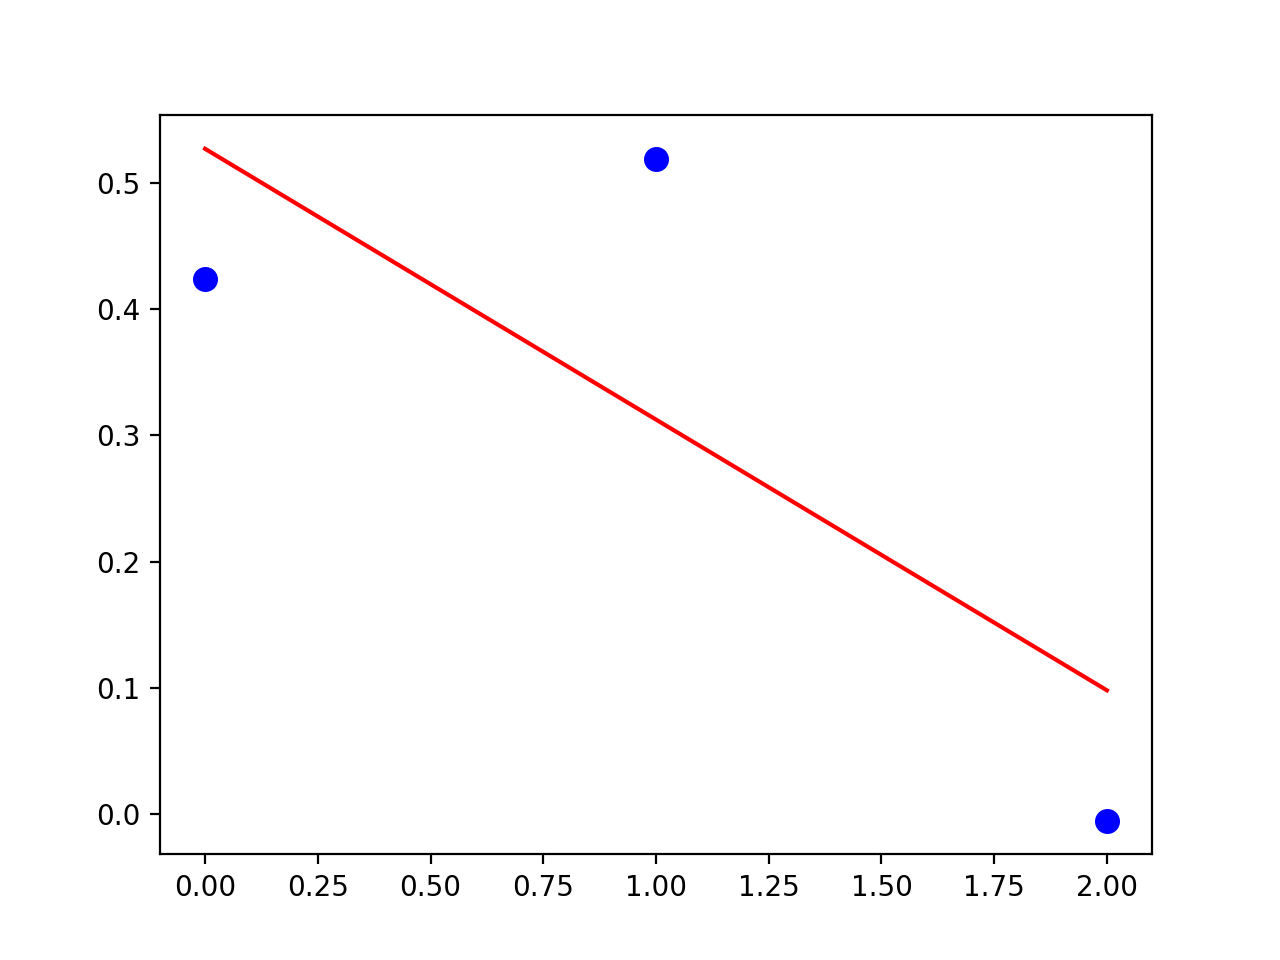

In [11]:
%matplotlib nbagg
import matplotlib.pyplot as plt

n = 50

qgrid_df = qgrid_widget.get_changed_df()
x = qgrid_df.index
y = qgrid_df['C']

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
line, = ax.plot(x, fit[0] * x + fit[1], color='red')
scatter, = ax.plot(x,y,ms=8,color='b',marker='o',ls='')

def handle_filter_changed(event, widget):
    qgrid_df = qgrid_widget.get_changed_df()
    x = qgrid_df.index
    y = qgrid_df['C']
    fit = np.polyfit(x, y, deg=1)
    line.set_data(x, fit[0] * x + fit[1])
    fig.canvas.draw()
    scatter.set_data(x, y)
    fig.canvas.draw()

qgrid_widget.on('filter_changed', handle_filter_changed)

In [3]:
qgrid_widget # render the qgrid widget again so we don't have to scroll to see the changes in the scatter plot

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Example 2 - Filter matplotlib price chart using qgrid
This example is basically a repeat of Example 1, except with a line chart of some pricing data for the S&P 500 instead of a scatter plot.

First, execute the following two cells. Once you do that you should see a qgrid instance and a matplotlib line chart showing the same data as the qgrid instance. Next, set some filters on the columns of the qgrid instance and watch what happens to the line chart (it should update immediately to reflect the filtering changes).

In [5]:
import pandas as pd
import numpy as np
import qgrid
randn = np.random.randn

# Get a pandas DataFrame containing the daily prices for the S&P 500 from 1/1/2014 - 1/1/2017
from pandas_datareader.data import DataReader
spy = DataReader(
    'SPY',
    'yahoo',
    pd.Timestamp('2014-01-01'),  
    pd.Timestamp('2017-01-01'),
)
# Tell qgrid to automatically render all DataFrames and Series as qgrids.
qgrid.enable()

# Render the DataFrame as a qgrid automatically
spy_qgrid = qgrid.show_grid(spy)
spy_qgrid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<IPython.core.display.Javascript object>


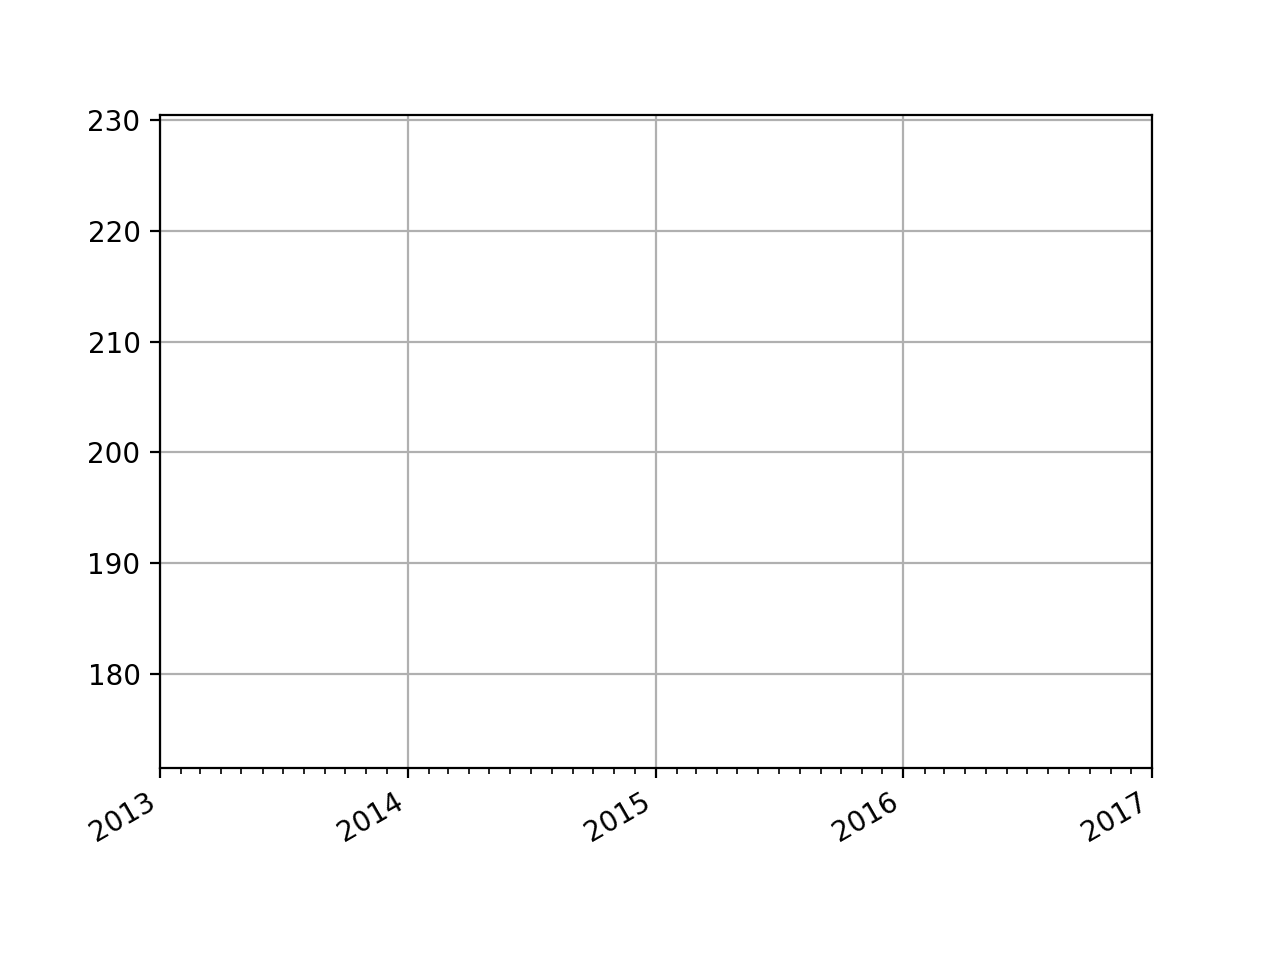

In [6]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from traitlets import All

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

n = 50
qgrid_spy_df = spy_qgrid.get_changed_df()
x = qgrid_spy_df.index
y = qgrid_spy_df['Close']

fig, ax = plt.subplots()
line, = ax.plot(x, y)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(x.min().year, 1, 1)
datemax = datetime.date(x.max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)

# format the coords message box
def price(x):
    return '$%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

def handle_filter_changed(event, widget):
    qgrid_spy_df = widget.get_changed_df()
    x = qgrid_spy_df.index
    y = qgrid_spy_df['Close']
    
    datemin = datetime.date(x.min().year, 1, 1)
    datemax = datetime.date(x.max().year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    
    line.set_data(x, y)
    fig.canvas.draw()

spy_qgrid.on('filter_changed', handle_filter_changed)

In [7]:
spy_qgrid # render the qgrid widget again so we don't have to scroll to see the changes in the scatter plot

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Example 3 - Logging all events
In this example we'll see how you can listen for events from any qgrid instance using the `qgrid.on` method.

Execute the following two cells. The first cell will create an empty output widget, and the second cell use the `on` method to listen for all events from all qgrid instances. Once the cells are executed, try interacting with any of the qgrid instances you created earlier in the notebook (i.e. by sorting, filtering, scrolling, etc).  Then scroll back down to this output widget and you'll notice that any actions that you took got printed to the output widget.

In practice you'd probably want to do something more interesting than just print these events to the notebook, such as  log the events to a service that you use to track user interactions.  This is just a proof-of-concept to show which events are available.

In [8]:
import ipywidgets as widgets
json_updates = widgets.Output(layout={'border': '1px solid black'})
user_interactions = widgets.Output(layout={'border': '1px solid black'})

widgets.VBox([user_interactions, json_updates])

In [9]:
import qgrid
from traitlets import All

def handle_all_events(event, qgrid_widget):
    output_area = json_updates if event['name'] == 'json_updated' else user_interactions
    with output_area:
        print(event)

qgrid.on(All, handle_all_events)

## Example 4 - Filter qgrid using ipywidgets slider (experimental)
In the Example 1 and 2, qgrid was being used to control other visualizations. In this example, we're going to invert the direction of control and use another visualization (in this case an ipywidget slider) to control qgrid.

Please note that the `_handle_qgrid_msg_helper` method used in this example is not a documented part of the API yet and should be considered experimental. It will likely be renamed and changed slightly once it gets officially added to the API.

First, execute the following cell. Once you do that you should see a slider widget directly above a qgrid widget. The slider is hooked up to control the filter for the index column. Next, move the sliders on the slider widget and watch qgrid instance update immediately to reflect the filtering changes.

In [10]:
import numpy as np
import pandas as pd
import qgrid
import ipywidgets as widgets
df_scale = pd.DataFrame(np.random.randn(1000, 4), columns=list('ABCD'))
q_scale = qgrid.show_grid(df_scale, show_toolbar=False)

int_range = widgets.IntRangeSlider(
    value=[0, 999],
    min=0,
    max=999,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

def on_value_change(change):
    q_scale._handle_qgrid_msg_helper({
        'field': "index",
        'filter_info': {
            'field': "index",
            'max': change['new'][1],
            'min': change['new'][0],
            'type': "slider"
        },
        'type': "filter_changed"
    })

int_range.observe(on_value_change, names='value')

widgets.VBox([int_range, q_scale])